In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import json
import gzip
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pyarrow as pa

# Run these commands in your terminal or notebook before execution:
#
# pip install pandas numpy matplotlib scikit-learn plotly wordcloud pyarrow fastparquet nbformat

## Introduction:

1. Identify the predictive task you will study.
○ Describe how you will evaluate your model at this predictive task
○ What relevant baselines can be used for comparison
○ How you will assess the validity of your model’s predictions?

## Data collection and Pre-processing:

### Steam Dataset Context:

This dataset comes from Steam, one of the largest digital game library platforms for PC (Computer) and distributes video games. In this specific dataset there is user behavior (people who bought, reviewed, or played these games) such as the following:

* Game Purchases
* Player Activity
* Written Reviews

The data was originally collected and for research purposes by Julian McAuley’s Lab at UC San Diego, and has been used in recommender-system research.

In [20]:
items = pd.read_parquet("items.parquet")
reviews = pd.read_parquet("reviews.parquet")

The full dataset includes the following:
* Reviews: 7,793,069
* Users: 2,567,538
* Items: 15,474
* Bundles: 615

And also metadata for genres, prices, discount history, and bundle composition.

The following table is used for variable descriptions and information for the items dataset:

| Variable Name   | Type           | Description                                                                                                                                                                                                                                                                                        |
| --------------- | -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **user_id**     | string         | The username and Steam profile identifier. Can be customized (ex: "js41637") or numeric SteamID64.                                                                                                                                                                                                    |
| **items_count** | integer        | Total number of Steam items (games, DLCs, software) owned by the user.                                                                                                                                                                                                                             |
| **steam_id**    | string/integer | The numeric SteamID64 corresponding to the user; used to join with other Steam metadata.                                                                                                                                                                                                           |
| **user_url**    | string         | Direct link to the user’s Steam profile.                                                                                                                                                                                                                                                           |
| **items**       | list of dicts  | A list where each entry contains metadata about a game the user owns. Each dictionary includes: <br>• **item_id** (string): Unique game ID on Steam <br>• **item_name** (string): Name of the game <br>• (Optionally) **genre**, **discounted_price**, etc. depending on dataset version |


In [19]:
items.head()

user_id  items_count           steam_id  \
0  76561197970982479          277  76561197970982479   
1            js41637          888  76561198035864385   
2          evcentric          137  76561198007712555   
3         Riot-Punch          328  76561197963445855   
4              doctr          541  76561198002099482   

                                            user_url  \
0  http://steamcommunity.com/profiles/76561197970...   
1               http://steamcommunity.com/id/js41637   
2             http://steamcommunity.com/id/evcentric   
3            http://steamcommunity.com/id/Riot-Punch   
4                 http://steamcommunity.com/id/doctr   

                                               items  
0  [{'item_id': '10', 'item_name': 'Counter-Strik...  
1  [{'item_id': '10', 'item_name': 'Counter-Strik...  
2  [{'item_id': '1200', 'item_name': 'Red Orchest...  
3  [{'item_id': '10', 'item_name': 'Counter-Strik...  
4  [{'item_id': '300', 'item_name': 'Day of Defea...

The following table is used for variable descriptions and information for the reviews dataset:

| Variable Name | Type          | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ------------- | ------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **user_id**   | string        | The ID of the user posting the reviews. Matches `user_id` in the items dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| **user_url**  | string        | Direct link to the user’s Steam profile; same as in items dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| **reviews**   | list of dicts | A list of all reviews the user has written. Each review dictionary includes fields like: <br>• **funny**: Number of "funny" reactions or empty string if none <br>• **helpful**: Rating such as `"15 of 20 people found this helpful"` or `"No ratings yet"` <br>• **id**: Steam review ID <br>• **item_id**: Game being reviewed <br>• **posted**: Date/time the review was posted <br>• **recommend**: Boolean indicating if the user recommended the game <br>• **review_text**: The free-text written review |


In [21]:
reviews.head()

user_id                                           user_url  \
0  76561197970982479  http://steamcommunity.com/profiles/76561197970...   
1            js41637               http://steamcommunity.com/id/js41637   
2          evcentric             http://steamcommunity.com/id/evcentric   
3              doctr                 http://steamcommunity.com/id/doctr   
4          maplemage             http://steamcommunity.com/id/maplemage   

                                             reviews  
0  [{'funny': '', 'helpful': 'No ratings yet', 'i...  
1  [{'funny': '', 'helpful': '15 of 20 people (75...  
2  [{'funny': '', 'helpful': 'No ratings yet', 'i...  
3  [{'funny': '', 'helpful': '2 of 2 people (100%...  
4  [{'funny': '3 people found this review funny',...

In [3]:
items['items'].iloc[0]

array([{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_2weeks': 0, 'playtime_forever': 6},
       {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_2weeks': 0, 'playtime_forever': 7},
       {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '50', 'item_name': 'Half-Life: Opposing Force', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '60', 'item_name': 'Ricochet', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '70', 'item_name': 'Half-Life', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '130', 'item_name': 'Half-Life: Blue Shift', 'playtime_2weeks': 0, 'playtime_forever': 0},
       {'item_id': '300', 'item_name': 'Day of Defeat: Source', 'playtime_2weeks': 0, 'playtime_forever': 4733},
       {'item_id': '240', 'item_name': 'Counter-Strik

In [4]:
reviews['reviews'].iloc[17]

array([{'funny': '17 people found this review funny', 'helpful': '28 of 31 people (90%) found this review helpful', 'item_id': '220200', 'last_edited': '', 'posted': 'Posted February 17, 2015.', 'recommend': True, 'review': "I'm going to keep this somewhat short and sweetAt the time of writing, Kerbal space program is in beta and there is talk of how soon it will be until it emerges from beta. But since its release in July 2011, it grown to become an outstanding example of Enthusiasm, Humor, and Profound triamph in a game. No matter whether your accomplishing great feats of exploration and scientific achievement......Or maybe you watched your beloved ship erupt into flames and debris becuase of a fatally unseen flaw. There is always something spectacular to be seen (Like your blown-up ship) or something to have a laugh at (Again like your blown-up ship)My recommendation?Buy this game, do something great, do something ridiculous, mod it, find something else just as great and just as cra

In [5]:
def flatten_reviews(df):
    """Expand the nested review arrays into a flat DataFrame."""
    rows = []
    for user_reviews in df['reviews']:
        if isinstance(user_reviews, (list, np.ndarray)):
            for r in user_reviews:
                if isinstance(r, dict) and 'review' in r:
                    rows.append({
                        'user_id': r.get('user_id', None),
                        'item_id': r.get('item_id', None),
                        'review': r.get('review', '').strip(),
                        'recommend': r.get('recommend', False)
                    })
    return pd.DataFrame(rows)

flat_reviews = flatten_reviews(reviews)

# Drop missing or empty reviews
flat_reviews = flat_reviews[flat_reviews['review'].str.len() > 5].reset_index(drop=True)

print(f"✅ Flattened reviews: {len(flat_reviews)} rows")
print(flat_reviews.head(3))

✅ Flattened reviews: 57407 rows
  user_id item_id                                             review  \
0    None    1250  Simple yet with great replayability. In my opi...   
1    None   22200               It's unique and worth a playthrough.   
2    None   43110  Great atmosphere. The gunplay can be a bit chu...   

   recommend  
0       True  
1       True  
2       True  


In [6]:
flat_reviews = flat_reviews[flat_reviews['review'].str.len() > 5].reset_index(drop=True)
flat_reviews['review_length'] = flat_reviews['review'].str.split().apply(len)

## Exploratory Analysis:

In [7]:
summary_table = pd.DataFrame({
    "Total Reviews": [len(flat_reviews)],
    "Positive (Recommend=True)": [flat_reviews['recommend'].sum()],
    "Negative (Recommend=False)": [(~flat_reviews['recommend']).sum()],
    "Average Review Length": [flat_reviews['review_length'].mean()],
    "Median Review Length": [flat_reviews['review_length'].median()]
})
print(summary_table)

   Total Reviews  Positive (Recommend=True)  Negative (Recommend=False)  \
0          57407                      50738                        6669   

   Average Review Length  Median Review Length  
0               39.83819                  15.0  


In [8]:
fig1 = px.histogram(flat_reviews, x='recommend', color='recommend',
                    title="Distribution of Recommendations",
                    labels={'recommend': 'Recommend'},
                    color_discrete_map={True: 'green', False: 'red'})
fig1.show()

In [9]:
# Review Length Distribution
fig2 = px.histogram(flat_reviews, x='review_length', nbins=50, color='recommend',
                    title="Distribution of Review Lengths by Recommendation",
                    labels={'review_length': 'Word Count'},
                    color_discrete_map={True: 'green', False: 'red'})
fig2.show()


In [10]:
# Boxplot of Review Lengths
fig3 = px.box(flat_reviews, x='recommend', y='review_length', color='recommend',
              title="Boxplot of Review Lengths by Recommendation",
              labels={'recommend': 'Recommend', 'review_length': 'Word Count'},
              color_discrete_map={True: 'green', False: 'red'})
fig3.show()

In [11]:
# Correlation Gauge
corr_val = flat_reviews[['review_length', 'recommend']].corr().iloc[0, 1]
fig4 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=corr_val,
    title={'text': "Correlation: Review Length vs Recommendation"},
    gauge={'axis': {'range': [-1, 1]}, 'bar': {'color': "blue"}}
))
fig4.show()

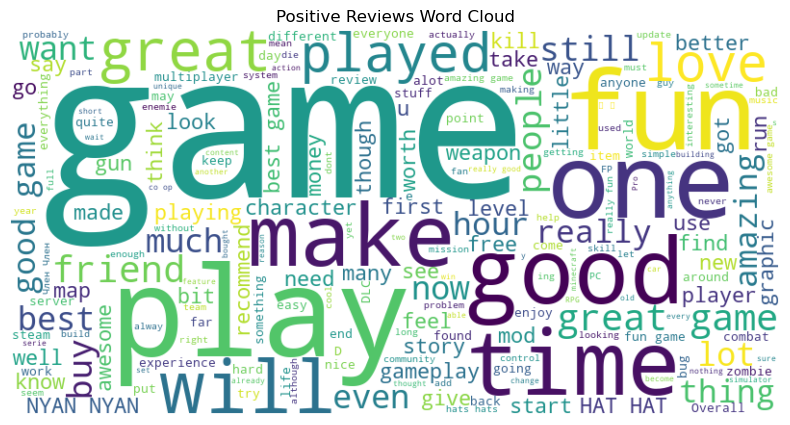

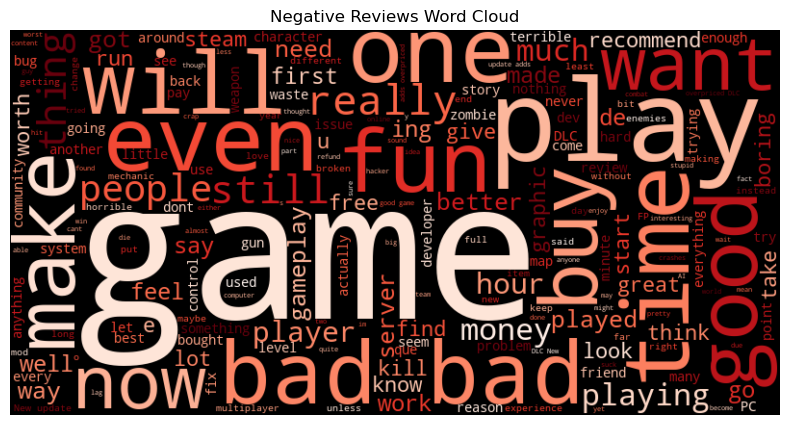

In [12]:
# --- Step 5: Word Clouds (Matplotlib) ---
positive_text = " ".join(flat_reviews[flat_reviews['recommend']]['review'].tolist())
negative_text = " ".join(flat_reviews[~flat_reviews['recommend']]['review'].tolist())

pos_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
neg_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()

In [13]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)
)

X = tfidf.fit_transform(flat_reviews['review'])
y = flat_reviews['recommend'].astype(int)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
logreg = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear'
)
logreg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [16]:
y_pred = logreg.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(classification_report(y_test, y_pred, digits=3))

# Optional: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)



--- Model Evaluation ---
Balanced Accuracy: 0.8004
              precision    recall  f1-score   support

           0      0.400     0.748     0.521      1334
           1      0.963     0.853     0.904     10148

    accuracy                          0.840     11482
   macro avg      0.681     0.800     0.713     11482
weighted avg      0.897     0.840     0.860     11482


Confusion Matrix:
[[ 998  336]
 [1496 8652]]


In [17]:
def show_top_features(model, vectorizer, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_[0]
    top_pos = np.argsort(coefs)[-n:]
    top_neg = np.argsort(coefs)[:n]
    print("\nTop Positive (Recommend=True):")
    print(feature_names[top_pos])
    print("\nTop Negative (Recommend=False):")
    print(feature_names[top_neg])

show_top_features(logreg, tfidf)


Top Positive (Recommend=True):
['highly' 'cool' 'awsome' 'fantastic' 'addicting' 'definitely'
 'great game' 'excellent' '10 10' 'great' 'fun' 'best' 'love' 'amazing'
 'awesome']

Top Negative (Recommend=False):
['worst' 'boring' 'horrible' 'terrible' 'unless' 'overkill' 'uninstall'
 'refund' 'microtransactions' 'awful' 'sucks' 'repetitive' 'crap'
 'unplayable' 'waste']


1. Identify the predictive task you will study
## Task Definition
Predict whether a Steam user will **recommend (`True`)** or **not recommend (`False`)** a game based solely on the text of their written review.  
This is a **binary classification task** using supervised learning.

---

## Model Type
**Logistic Regression classifier** trained on **TF-IDF text features**.

---

## 📏 Evaluation Metrics

**Primary:**
- Balanced Accuracy  
- F1-Score *(handles class imbalance)*  

**Secondary:**
- Precision  
- Recall  
- ROC-AUC  

---

## Baselines for Comparison
- Majority-class predictor *(“always recommend”)*  
- Random guessing baseline  
- Simple keyword heuristic *(e.g., review contains “recommend”)*  

---

## Validity of Predictions
- **Confusion matrix** → to inspect Type I / Type II errors  
- **Feature weight analysis** → identify top positive and negative words  
- **Cross-validation** → to verify model robustness and stability  



2. Exploratory analysis, data collection, pre-processing, and discussion:

3. Modeling:

4. Evaluation:

5. Discussion of related work:

# Citations

In [ ]:
# ## potential alternative dataset to use

# import ast

# path = "steam_reviews.json.gz"

# rows = []
# with gzip.open(path, 'rt', encoding='utf-8') as f:
#     for line in f:
#         line = line.strip()
#         if not line:
#             continue
#         try:
#             rows.append(ast.literal_eval(line))
#         except Exception as e:
#             # Skip any malformed lines
#             print("Skipping bad line:", e)
#             continue

# df = pd.DataFrame(rows)
# print(df.shape)
# print(df.columns)
# df.head()